# Part I: Basic
***

Student ID: A0248839J  
Name: Dahyun Kim

## 0. Instruction 
* In this part, given a texture sample, you need to generate a larger texture image with similar visual appearance to the sample using to the synthesis algorithms we discussed in class.  
    1. First, create a large empty image (E) and copy the texture sample (T) to its upper left corner as a starting point for your synthesis program.
    2. Iteratively replace the blank pixels (empty regions) in empty image (E) with the pixels from the texture smaple (T). At each iteration, a blank pixel with the largest number of 'known' neighboring pixels is replaced. The pixel selected from texture sample has the closest neighborhood to the blank pixel among all sample pixels. The similarity of neighborhood is evaluated by a Gaussian weighted SSD.
    3. Show at least 3 different results.
    4. Discuss your findings through the experiment, particularly: how the neighborhood size affects the synthesis results and speed? What kind of data works best/worst? How the implemented algorithm can be improved in terms of result quality and efficiency.


## 1. Import libraries
* Import all the libraries.

In [1]:
# Import lib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import timeit

## 2.  Function `fill_pixel`
* The function `fill_pixel` approches to the blank pixels and iteratively replaces the pixels using `Synthesize_pixel` function, retuning a larger texture image `new_img_array`.

* Because a blank pixel with the largest number of 'known' neighboring pixel should be replaced, the blank pixel is filled from right to left, and then bottom to top, and the iteration ends with fillng the pixel in the lower right corner.

* `fill_pixel` assumes that the `new_img_array` is a square.

In [21]:
def fill_pixel(img_array, new_img_array, window_size):

    y_shape, x_shape = img_array.shape
    new_y_shape, new_x_shape = new_img_array.shape
    
    # Zero pad the new image to get the neighborhood windows of the edges.
    window_r = math.trunc(window_size/2)
    new_img_array_pad = np.zeros((new_x_shape + 2*window_r, new_y_shape + 2*window_r)) 
    new_img_array_pad[window_r:window_r+new_x_shape, window_r:window_r+new_y_shape] = new_img_array
 
    #fill pixels 
    for iter in range(0, max(new_x_shape - x_shape, new_y_shape - y_shape)):    
        print('iteration: ', iter)
        x0 = min(x_shape - 1 + iter, new_x_shape - 1)
        y0 = min(y_shape + iter, new_y_shape - 1)
        x1 = min(x_shape + iter, new_x_shape - 1)
        y1 = min(y_shape -1 + iter, new_y_shape - 1)
        #print('x0:',x0, 'y0:',y0, 'x1:', x1, 'y1:', y1)
        
        # fill right to left
        if y0 < new_y_shape:
            for under_fill in range(0, x_shape+iter):
                pixel = Synthesize_pixel(x0-under_fill, y0, img_array, new_img_array_pad, window_size)
                new_img_array[x0-under_fill, y0] = pixel
                #print(x0-under_fill, y0, 'filled')
        else:
            y0 = new_y_shape - 1

        #fill bottom to top
        if x1 < new_x_shape:
            for upper_fill in range(0, y_shape + iter):
                pixel = Synthesize_pixel(x1, y1 - upper_fill, img_array, new_img_array_pad, window_size)
                new_img_array[x1, y1 - upper_fill] = pixel
                #print(x1, y1 - upper_fill, 'filled')
        else:
            x1 = new_x_shape - 1
            
        #fill the lower right corner
        pixel = Synthesize_pixel(x1, y0, img_array, new_img_array_pad, window_size)
        new_img_array[x1, y0] = pixel
        #print(x1, y0, 'filled')        
    
    return new_img_array  

## 3. Funtion `Synthesize_pixel`
* The function `Synthesize_pixel` synthesizes a pixel `(x,y)`. It Uses *Efros & Leung Algorithm* for texture synthesis.
* `neigh_window` is the neighborhood of pixels around `(x,y)`. The dimension is `window_size*window_size`.
* `match_window` is a match in the input imamge (texture sample T).
* The center pixeles of every `match_window` are stored in the array `match_list`, and the SSD valuses of every `match_window` are stored in the array `ssd_list`. The best 4 center pixels are stored in `best_match`, and one pixel is picked at random, which is the return value of the funcion `Synthesize_pixel`.

In [22]:
# Performs Texture Synthesis for a pixel (x,y)
def Synthesize_pixel(x, y, img_array, new_img_array_pad, window_size):
    #new_x_shape, new_y_shape = new_img_array.shape
    x_shape, y_shape = img_array.shape
    
    window_r = math.trunc(window_size/2)   # Calculate the window radius / assume the window is always a squre
    #print('window radius:', window_r) #4
    
    # Get the coordinates for the neighborhood window (in new_img_array (E))    
    #{x0,y0    ...
    #          ...
    #          ...     x1,y1}            
    x0 = x
    x1 = x + 2*window_r
    y0 = y
    y1 = y + 2*window_r
    #print('window: x=',x0,':', x1, 'y=',y0,":",y1)
    
    neigh_window = new_img_array_pad[x0:x1, y0:y1]
    #mask_window = mask[x0:x1, y0:y1]
    
    match_list = []
    ssd_list = []
    best_match = []
    
    
    # Find matches in the texture sample (T)
    for i in range(window_r, x_shape - window_r -1):
        for j in range(window_r, y_shape - window_r -1):
            #print('(i,j)',i,j)
            
            match_window = img_array[i-window_r:i+window_r, j-window_r:j+window_r]
            #print('match window T shape: ', match_window.shape) # 8,8
            # Caculate the similarity of neighborhood (Gaussian Weighted SSD)
            dis = match_window - neigh_window
            #sq_dis = dis*dis*mask_window # leave out the blank pixels
            sq_dis = dis*dis
            ssd = np.sum(sq_dis) # Gaussian Weighted SSD
            #print('ssd = ', ssd)
            
            #print('candidate pixel: ', match_window[window_r,window_r])
            match_list.append(match_window[window_r,window_r])
            ssd_list.append(ssd)
            
    # Get the best 4 matches
    for i in range(0,4):
        index = np.argmin(ssd_list)
        best_match.append(match_list[index])

        np.delete(match_list, index)
        np.delete(ssd_list, index)
    
    # Sample at random
    random_index = random.randint(0, len(best_match)-1)
    
    return best_match[random_index]

## 4. Read texture sample (T)
* The code below reads texture sample (T) and changes it into np array `img_array`.

(64, 64)


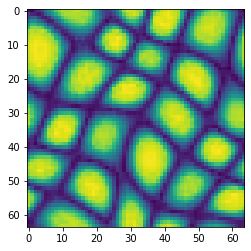

In [23]:
# Read texture sample (T) and change into np array
path = "pic1.jpg"              #64, 64
img = Image.open(path)
img_array = img.convert("L")    #greyscale
img_array = np.array(img_array)
x_shape, y_shape = img_array.shape
plt.imshow(img_array)
print(img_array.shape)

## 5. Create empty image (E)
* Part I-1
* An empty image `new_img_array` is created and the upper left corner is filled with the texture sample `img_array`.

(80, 80)


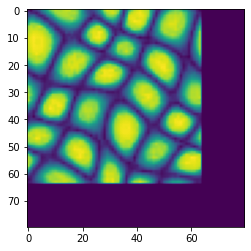

In [24]:
# Create empty image (E) and copy the texture sample (T)
# to its upper left corner.
new_x_shape = 80
new_y_shape = 80
new_img_array = np.zeros((new_x_shape,new_y_shape))
new_img_array[0:x_shape, 0:y_shape] = img_array
plt.imshow(new_img_array)
print(new_img_array.shape)

In [6]:
# # Make a mask array
# mask = np.ones((new_x_shape,new_y_shape)) < 0
# mask[0:x_shape, 0:y_shape] = True

## 6. Generate a larger texture image
* Part I-2
* Generate a larger texture image `new_img_array` using `fill_pixel`.
* The `window_size` is the neighborhood size.

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
Runtime:  19.301292199999807


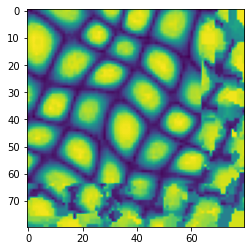

In [25]:
# Perform
try:
    start = timeit.default_timer()
    
    window_size = 40 # neighborhood size
    new_img_array = fill_pixel(img_array, new_img_array, window_size)
    
    stop = timeit.default_timer()
    
    plt.imshow(new_img_array)
    print('Runtime: ', stop - start) #73s for window size 21, 96sec for window size 11
    
except Exception as e:
    print('Error: ', e)
    plt.imshow(new_img_array)
    pass

## 7. Different results
* These are results of different texture samples.

(80, 80)


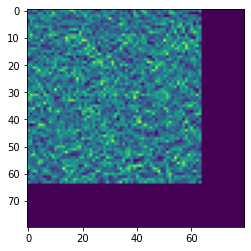

In [26]:
# open img
path = "pic2.jpg"
img = Image.open(path)
img_array = img.convert("L")
img_array = np.array(img_array)
x_shape, y_shape = img_array.shape

# Create empty image (E) and copy the texture sample (T)
# to its upper left corner.
new_x_shape = 80
new_y_shape = 80
new_img_array = np.zeros((new_x_shape,new_y_shape))
new_img_array[0:x_shape, 0:y_shape] = img_array
plt.imshow(new_img_array)
print(new_img_array.shape)

# # Make a mask array
# mask = np.ones((new_x_shape,new_y_shape)) < 0
# mask[0:x_shape, 0:y_shape] = True

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15


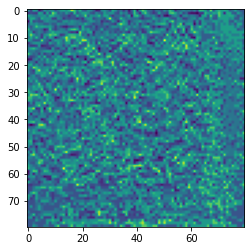

In [27]:
# Perform
try:
    window_size = 40
    new_img_array = fill_pixel(img_array, new_img_array, window_size)
      
    plt.imshow(new_img_array)
except Exception as e:
    print('Error: ', e)
    
    plt.imshow(new_img_array)
    pass

(80, 80)


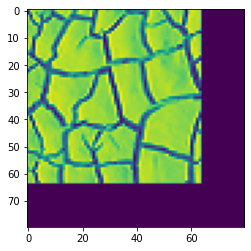

In [28]:
# open img
path = "pic3.jpg"
img = Image.open(path)
img_array = img.convert("L")
img_array = np.array(img_array)
x_shape, y_shape = img_array.shape

# Create empty image (E) and copy the texture sample (T)
# to its upper left corner.
new_x_shape = 80
new_y_shape = 80
new_img_array = np.zeros((new_x_shape,new_y_shape))
new_img_array[0:x_shape, 0:y_shape] = img_array
plt.imshow(new_img_array)
print(new_img_array.shape)

# # Make a mask array
# mask = np.ones((new_x_shape,new_y_shape)) < 0
# mask[0:x_shape, 0:y_shape] = True

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15


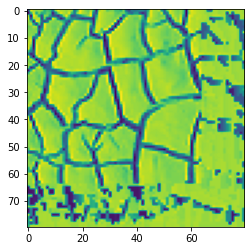

In [29]:
# Perform
try:
    window_size = 40
    new_img_array = fill_pixel(img_array, new_img_array, window_size)
    
    plt.imshow(new_img_array)
except Exception as e:
    print('Error: ', e)
    
    plt.imshow(new_img_array)
    pass

## 8. Discuss
1. how the neighborhood size affects the synthesis results and speed?  
* If the neighborhood size is too small, the algorithm fails to fill the blank pixels that is too far away from the original image, just leaving it blank or filling them with a same color. Thus, the neighborhood size must be large enough for the algorithm to get the grasp of the whole picture. Also, increasing the neighborhood size increases the speed of calculation, because the number of the matches (candidates) in the input image becomes less with a larger neighborhood size.


2. What kind of data works best/worst?
* As you can see from the examples above, image with more fine texture works better. For example, the second image worked best because it had the most fine texture, whereas the result of the third image was not very sucessful.  


3. How can the implemented algorithm be improved in terms of result quality and efficiency?
* The implemented algorithm search the whole input image for finding the best candidate. If only the necessary parts in the input image can be searched, the algorithm will be much more efficient.